In [143]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [163]:
# download training and test data from open datasets
training_data = datasets.FashionMNIST(
    root="data", 
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.FashionMNIST(
    root="data", 
    train=False,
    download=True,
    transform=ToTensor())

# create data loaders
batch_size = 64
train_dataloader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True)
test_dataloader = DataLoader(test_data,
                            batch_size=batch_size)

In [165]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class Autoencoder(nn.Module): # input/output: flattened image
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
print(model)

Using cuda device
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [166]:
### TRAINING

loss_fn = nn.MSELoss(reduction="mean") 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.view(-1, 28 * 28).to(device)
        
        # compute reconstruction error
        reconstructed = model(X)
        loss = loss_fn(reconstructed, X)

        # compute grads and optimize model params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f"mean loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [167]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.view(-1, 28 * 28).to(device)
            reconstructed = model(X)
            test_loss += loss_fn(reconstructed, X).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [168]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
----------------------------
mean loss: 0.177164 [    0/60000]
mean loss: 0.025834 [ 6400/60000]
mean loss: 0.019524 [12800/60000]
mean loss: 0.015386 [19200/60000]
mean loss: 0.016412 [25600/60000]
mean loss: 0.013062 [32000/60000]
mean loss: 0.011523 [38400/60000]
mean loss: 0.011186 [44800/60000]
mean loss: 0.010259 [51200/60000]
mean loss: 0.011044 [57600/60000]
Test Error: 
 Avg loss: 0.010409 

Epoch 2
----------------------------
mean loss: 0.010462 [    0/60000]
mean loss: 0.010666 [ 6400/60000]
mean loss: 0.008681 [12800/60000]
mean loss: 0.008882 [19200/60000]
mean loss: 0.009364 [25600/60000]
mean loss: 0.008279 [32000/60000]
mean loss: 0.009528 [38400/60000]
mean loss: 0.008375 [44800/60000]
mean loss: 0.008948 [51200/60000]
mean loss: 0.006745 [57600/60000]
Test Error: 
 Avg loss: 0.007995 

Epoch 3
----------------------------
mean loss: 0.007727 [    0/60000]
mean loss: 0.007171 [ 6400/60000]
mean loss: 0.007544 [12800/60000]
mean loss: 0.007925 [19200/60000]
mea

<Figure size 640x480 with 0 Axes>

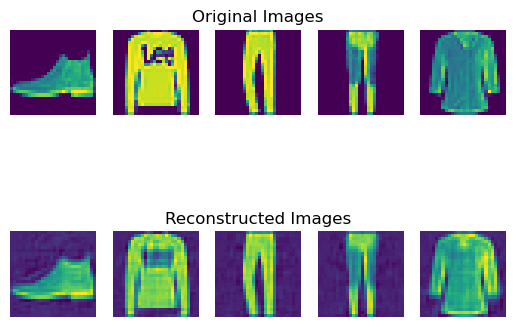

In [160]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


test_images = 5
plt.figure()
f, axarr = plt.subplots(2, test_images) 
axarr[0, 2].set_title("Original Images")
axarr[1, 2].set_title("Reconstructed Images")

model.eval()
with torch.no_grad():
    for i in range(test_images):
        axarr[0][i].axis("off")
        axarr[1][i].axis("off")

        # original images
        x, y = test_data[i][0], test_data[i][1]
        axarr[0, i].imshow(x.permute(1, 2, 0)) # permute tensor to be channels last
        # reconstructed images
        x = x.view(-1, 28*28).to(device)
        reconstructed = model(x).view(1, 28, 28)
        axarr[1, i].imshow(reconstructed.to("cpu").permute(1, 2, 0))

In [161]:
torch.save(model.state_dict(), "autoencoder.pth")
print("Saved PyTorch Model State to autoencoder.pth")

Saved PyTorch Model State to autoencoder.pth


In [162]:
# we need to recreate the model structure and then load the state dictionary into it
model = Autoencoder().to(device)
model.load_state_dict(torch.load("autoencoder.pth"))

<All keys matched successfully>